In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import warnings
import autogluon
warnings.filterwarnings('ignore')

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load
df = pd.read_csv('data/tsa_passenger_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.iloc[7:]

In [3]:
# Format 
df = df.rename(columns={
    'date': 'timestamp',
    'passenger_volume': 'target'
})

# Add an item_id column (required by AutoGluon for multi-series, even with single series)
df['item_id'] = 'passenger_volume'

# Reorder columns
df = df[['item_id', 'timestamp', 'target']]

In [4]:
# Splits
test_size = 7
val_size = 28
total_holdout = test_size + val_size

# Create the splits
train_df = df.iloc[:-total_holdout].copy() 
val_df = df.iloc[-total_holdout:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

# Convert to TimeSeriesDataFrame format
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
val_data = TimeSeriesDataFrame.from_data_frame(
    val_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="item_id",
    timestamp_column="timestamp"
)

In [5]:
# Train
predictor = TimeSeriesPredictor(
    target='target',
    freq='D',
    prediction_length=test_size,
    path='./autogluon-passenger-model',
    eval_metric='MAE',
    verbosity=2
)

predictor.fit(
    train_data,
    tuning_data=val_data,
    presets="best_quality",
    hyperparameters= {
        'RecursiveTabular': {
            'model_name': "GBM",
        }
    }
)

print("✅ Model training completed!")
print(f"Best model: {predictor.model_best}")


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Steve\Desktop\flight-tracking\autogluon-passenger-model'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
GPU Count:          1
Memory Avail:       17.18 GB / 31.86 GB (53.9%)
Disk Space Avail:   255.63 GB / 1862.21 GB (13.7%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'D',
 'hyperparameters': {'RecursiveTabular': {'model_name': 'GBM'}},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 7,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Provided train_data has 897 rows, 1 time series. Median time ser

✅ Model training completed!
Best model: RecursiveTabular


In [6]:
predictor.evaluate(train_data)

Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


{'MAE': -64775.5}

In [7]:
predictor.evaluate(val_data)['MAE'] / 7

Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


-8118.764910894598

In [8]:
# Make predictions on the test set
print("🔮 Making predictions...")

# For AutoGluon timeseries prediction, we use the training + validation data
# to predict the next time step (which corresponds to our test period)
prediction_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([train_df, val_df]), 
    id_column="item_id",
    timestamp_column="timestamp"
)

# Generate predictions for the next time step
predictions = predictor.predict(prediction_data)

print("✅ Predictions generated!")
print(f"Predictions shape: {predictions.shape}")
predictions


Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


🔮 Making predictions...
✅ Predictions generated!
Predictions shape: (7, 10)


mean           0.1           0.2  \
item_id          timestamp                                              
passenger_volume 2025-07-21  2.908966e+06  2.807581e+06  2.842385e+06   
                 2025-07-22  2.607919e+06  2.464538e+06  2.513758e+06   
                 2025-07-23  2.669150e+06  2.493546e+06  2.553828e+06   
                 2025-07-24  2.984563e+06  2.781792e+06  2.851399e+06   
                 2025-07-25  2.925523e+06  2.698819e+06  2.776642e+06   
                 2025-07-26  2.609104e+06  2.360763e+06  2.446013e+06   
                 2025-07-27  3.096120e+06  2.827880e+06  2.919961e+06   

                                      0.3           0.4           0.5  \
item_id          timestamp                                              
passenger_volume 2025-07-21  2.867481e+06  2.888924e+06  2.908966e+06   
                 2025-07-22  2.549249e+06  2.579574e+06  2.607919e+06   
                 2025-07-23  2.597295e+06  2.634436e+06  2.669150e+06   
                 2025-07-24  2.901591e+06  2.944477e+06  2.984563e+06   
                 2025-07-25  2.832758e+06  2.880707e+06  2.925523e+06   
                 2025-07-26  2.507485e+06  2.560010e+06  2.609104e+06   
                 2025-07-27  2.986358e+06  3.043092e+06  3.096120e+06   

                                      0.6           0.7           0.8  \
item_id          timestamp                                              
passenger_volume 2025-07-21  2.929009e+06  2.950452e+06  2.975548e+06   
                 2025-07-22  2.636263e+06  2.666589e+06  2.702079e+06   
                 2025-07-23  2.703865e+06  2.741006e+06  2.784473e+06   
                 2025-07-24  3.024648e+06  3.067534e+06  3.117726e+06   
                 2025-07-25  2.970340e+06  3.018289e+06  3.074404e+06   
                 2025-07-26  2.658199e+06  2.710724e+06  2.772195e+06   
                 2025-07-27  3.149148e+06  3.205881e+06  3.272278e+06   

                                      0.9  
item_id          timestamp                 
passenger_volume 2025-07-21  3.010352e+06  
                 2025-07-22  2.751299e+06  
                 2025-07-23  2.844754e+06  
                 2025-07-24  3.187333e+06  
                 2025-07-25  3.152227e+06  
                 2025-07-26  2.857446e+06  
                 2025-07-27  3.364359e+06

In [9]:
test_df

,item_id,timestamp,target
932,passenger_volume,2025-07-21,2886252
933,passenger_volume,2025-07-22,2451222
934,passenger_volume,2025-07-23,2629875
935,passenger_volume,2025-07-24,2968619
936,passenger_volume,2025-07-25,2969666
937,passenger_volume,2025-07-26,2669445
938,passenger_volume,2025-07-27,3017408


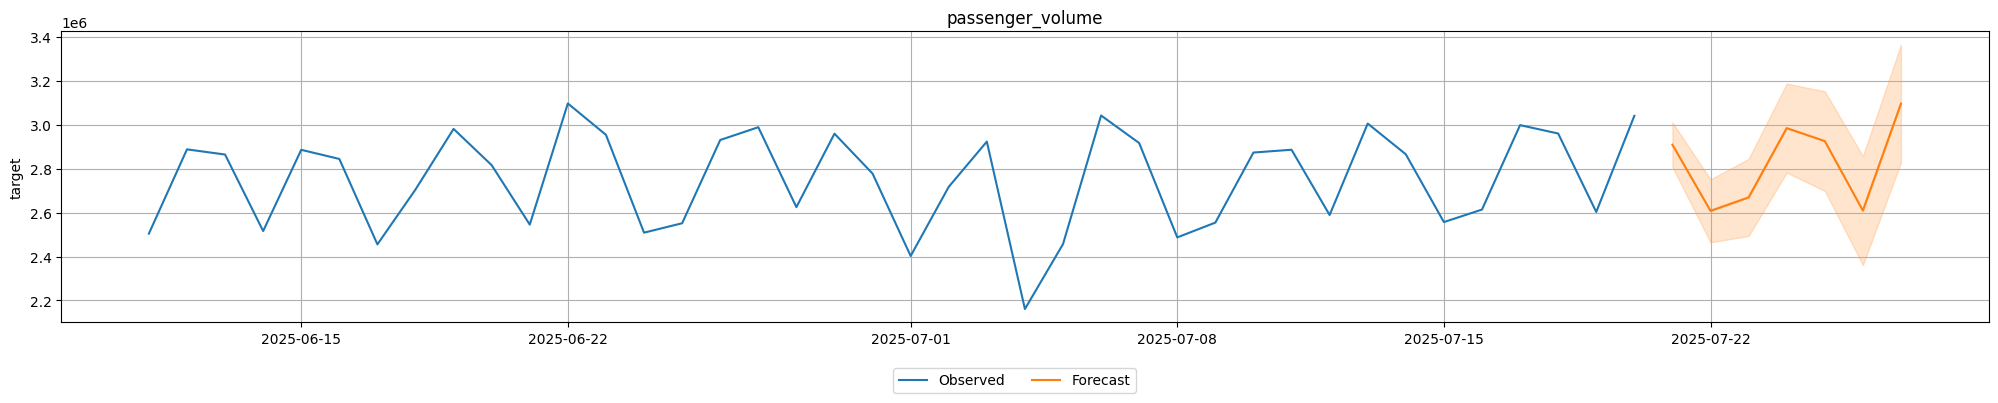

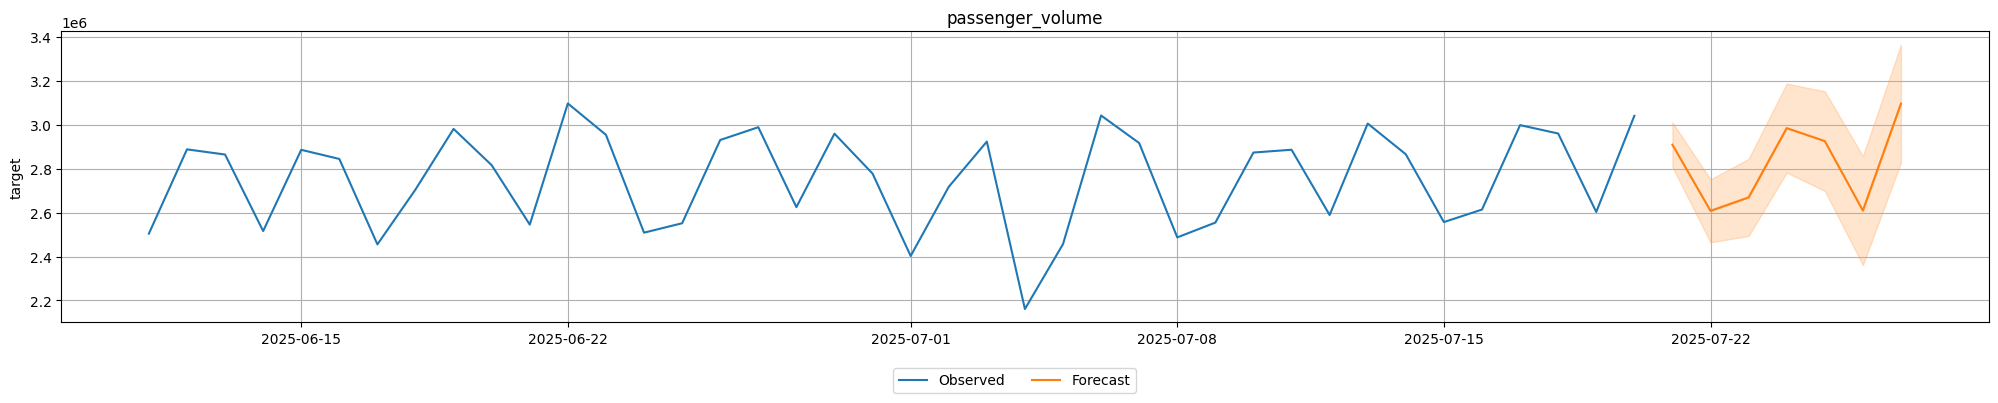

In [10]:
predictor.plot(prediction_data, predictions, max_history_length=40)

In [11]:
predictions["0.5"].sum() / 7

2828763.61157658

In [12]:
actual = 19592487 / 7
predicted = predictions["0.5"].sum() / 7
kalshi_market_prediction = 2810000

print("model error: ", actual - predicted)
print("kalshi error: ", actual - kalshi_market_prediction)

model error:  -29836.89729086589
kalshi error:  -11073.285714285914
